# **Работа с геоданными**

В этом задании вам предстоит научиться работать с географическими данными. В Питоне есть огромное количество библиотек, позволяющих эти данные обрабатывать и визуализировать; выберите ту, которая вам больше понравится. Вам может помочь руководство kaggle по работе с картами: "Семнадцать способов рисовать данные на картах". Смотрите также:

  - модуль basemap (пример, ещё пример)
  -  плагин gmaps
  - виджет ipyleaflet (крайне минималистичный пример)
  -  модуль folium

Поскольку мы агрегировали данные по равномерной сетке, можно ожидать, что существенное количество ячеек окажется в районах города, где вызов такси невозможен (реки, заливы, острова, парки). Теоретически ряды, соответствующие таким ячейка, должны состоять из одних нулей, но на практике это может быть не так: устройства, определяющие координаты автомобилей в момент начала поездки, несовершенны и могут ошибаться, показывая, например, что такси находится в середине реки. Чтобы правильно отобрать ячейки, вам понадобится визуализировать их границы на карте и отфильтровать те, из которых поездки на такси невозможны. 

## **Задание 0:** *Загрузка библиотек и опеределиние всех нужных функций*

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import datetime

from matplotlib import pylab as plt

from IPython.display import Image

# **Задание 1:** *Загрузка данных за май 2016 года (тест)* 

Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [2]:
data_taxi_may = pd.read_csv('cleaned_2016-05.csv', skipinitialspace = True, index_col=0)
data_taxi_may.head(2)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
regions = pd.read_csv('regions.csv', sep=';', skipinitialspace=True, index_col='region')
regions.head(2)

,west,east,south,north
region,,,,
1,-74.25559,-74.244478,40.496120,40.504508
2,-74.25559,-74.244478,40.504508,40.512896


In [4]:
regions_sums_dict = data_taxi_may.sum().to_dict()

regions_sums_df = pd.DataFrame({'trip_sums': regions_sums_dict.values()},
                  index=regions_sums_dict.keys() )

zero_zones = int(regions_sums_df[regions_sums_df['trip_sums'] == 0].count())

print(f'Total 2500 regions and {zero_zones} regions with zero trips.')

Total 2500 regions and 1283 regions with zero trips.


In [5]:
regions_sums_df['region'] = np.r_[1:2501]

In [6]:
regions_sums_df.tail(2)

,trip_sums,region
2499,0,2499
2500,0,2500


## **Задание 2:** *Empire State Building plotting*

Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

In [7]:
markers_df = pd.DataFrame(data={'Object': ['Empire State Building', 'Liberty Statue'],
                                'City': ['New York', 'New York'],
                                'Latitude': [40.748817, 40.689655],
                                'Longitude': [-73.985428, -74.043954]})

In [8]:
markers_df

,Object,City,Latitude,Longitude
0,Empire State Building,New York,40.748817,-73.985428
1,Liberty Statue,New York,40.689655,-74.043954


In [9]:
markers_df[markers_df.Object == 'Empire State Building']

,Object,City,Latitude,Longitude
0,Empire State Building,New York,40.748817,-73.985428


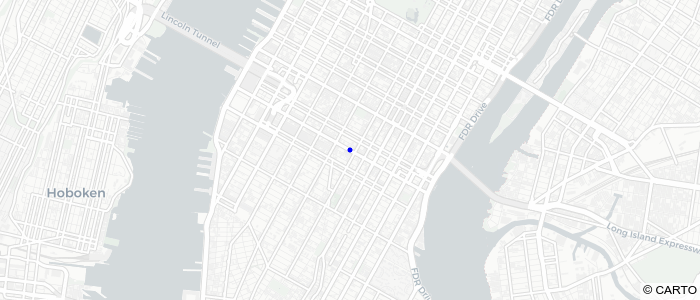

In [10]:
# import plotly.express as px

# fig = px.scatter_mapbox(markers_df[markers_df.Object == 'Empire State Building'], 
#                         lat="Latitude", lon="Longitude", hover_name="Object", hover_data=["Latitude", "Longitude"],
#                         color_discrete_sequence=["blue"], zoom=3, height=300)
# fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=12, mapbox_center={'lat': 40.748817, 'lon': -73.985428})
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# # fig.show()

# fig.write_image('images/fig1.png')

# Show chart
Image('images/fig1.png')

## **Задание 3:** *Sum of the trips plotting*

Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [11]:
grid_coordinates = {}

for i in range(regions.shape[0]):
    
    west = regions.iloc[i, 0]
    east = regions.iloc[i, 1]
    south = regions.iloc[i, 2]
    north = regions.iloc[i, 3]
    
    left_down = [west, south ]
    left_up = [west, north]
    right_up = [east, north]
    right_down = [east, south]
    
    grid_coordinates[i] = [left_down, left_up, right_up, right_down]

In [12]:
# We are going to create GeoJSON file from dictionary

def df_to_geojson(dictionary):
    # create a new python dict to contain our geojson data, using geojson format
    geojson = {'type': 'FeatureCollection', 'features': []}
    
    # loop through each row in the dataframe 
    for key, value in dictionary.items():
        # create a feature template to fill in
        feature = {'type': 'Feature', 
                   'properties': {},
                   'geometry': {'type':'Polygon',
                                'coordinates':[]}}
        
        # fill in the coordinates 
        feature['geometry']['coordinates'] = [value]
        
        # create properies with region id
        feature['properties']['region'] = key + 1
        # add this feature (convert dataframe row) to the list of features inside our dict
        geojson['features'].append(feature)
    
    return geojson

In [13]:
regions_json = df_to_geojson(grid_coordinates)

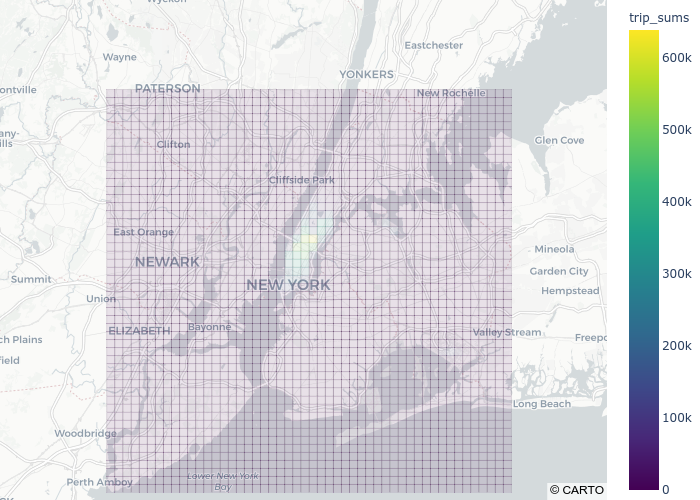

In [14]:
# import plotly.express as px

# fig = px.choropleth_mapbox(data_frame=regions_sums_df, 
#                            geojson=regions_json, 
#                            color="trip_sums",
#                            locations="region", 
#                            featureidkey="properties.region",
#                            opacity=0.1,
#                            color_continuous_scale='Viridis',
#                            center={"lat": 40.748817, "lon": -73.985428},
#                            mapbox_style="carto-positron", 
#                            zoom=9)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# # fig.show()

# fig.write_image('images/fig2.png')

# Show chart
Image('images/fig2.png')

## **Задание 4:** *Interactive map plotting*

Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

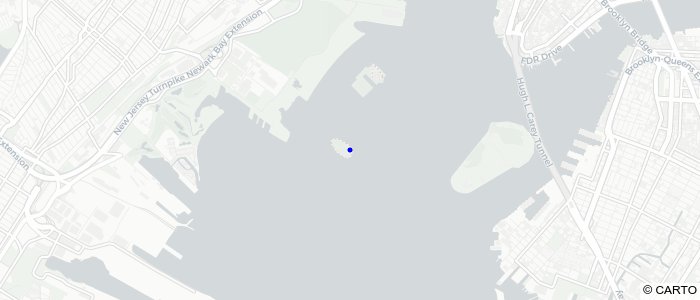

In [52]:
import plotly.express as px

fig = px.scatter_mapbox(markers_df[markers_df.Object == 'Liberty Statue'], 
                        lat="Latitude", lon="Longitude", hover_name="Object", hover_data=["Latitude", "Longitude"],
                        color_discrete_sequence=["blue"], zoom=3, height=300)
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=12, mapbox_center={'lat': 40.689655, 'lon': -74.043954})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

fig.write_image('images/fig3.png')

# Show chart
Image('images/fig3.png')

## **Задание 5:** *Mean trips on interactive map*

Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [20]:
regions_mean_dict = data_taxi_may.mean(axis=0).to_dict()

In [33]:
regions_sums_and_means_df = pd.DataFrame()
regions_sums_and_means_df['region'] = regions_sums_df['region']
regions_sums_and_means_df['trip_sums'] = regions_sums_df['trip_sums']
regions_sums_and_means_df['trip_means'] = regions_mean_dict.values()

In [34]:
regions_sums_and_means_df.head(2)

,region,trip_sums,trip_means
1,1,0,0.0
2,2,0,0.0


In [37]:
zero_zones2 = int(regions_sums_and_means_df[regions_sums_and_means_df['trip_means'] <= 5].trip_means.count())

print(f'Total 2500 regions and {zero_zones2} regions with zero trips.')

Total 2500 regions and 2398 regions with zero trips.


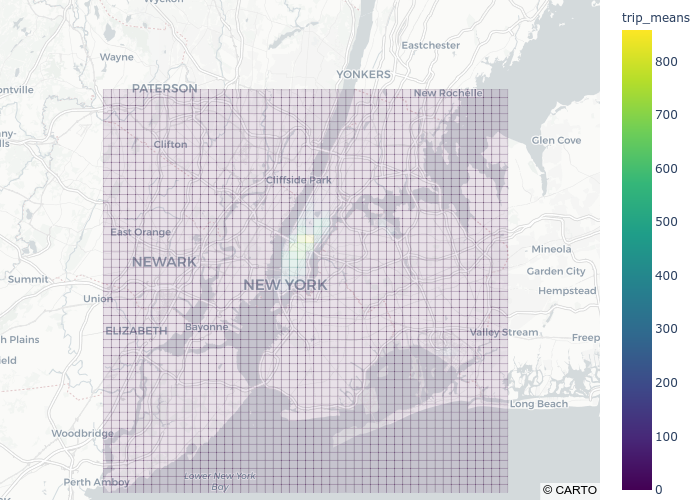

In [53]:
import plotly.express as px

fig = px.choropleth_mapbox(data_frame=regions_sums_and_means_df, 
                           geojson=regions_json, 
                           color="trip_means",
                           locations="region", 
                           featureidkey="properties.region",
                           opacity=0.1,
                           color_continuous_scale='Viridis',
                           center={"lat": 40.748817, "lon": -73.985428},
                           mapbox_style="carto-positron", 
                           zoom=9)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

fig.write_image('images/fig4.png')

# # Show chart
Image('images/fig4.png')

## **Задание 6:** *Regions filtering*

Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [39]:
regions_filtered_df = regions_sums_and_means_df[regions_sums_and_means_df['trip_means'] > 5]

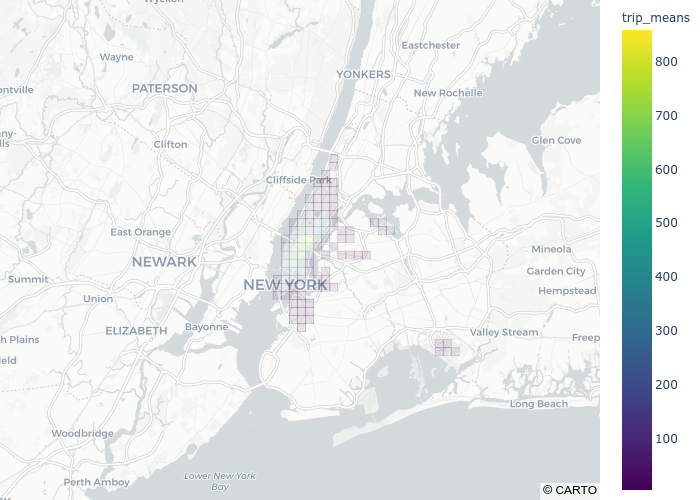

In [55]:
import plotly.express as px

fig = px.choropleth_mapbox(data_frame=regions_filtered_df, 
                           geojson=regions_json, 
                           color="trip_means",
                           locations="region", 
                           featureidkey="properties.region",
                           opacity=0.1,
                           color_continuous_scale='Viridis',
                           center={"lat": 40.748817, "lon": -73.985428},
                           mapbox_style="carto-positron", 
                           zoom=9)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

fig.write_image('images/fig5.png')

# # Show chart
Image('images/fig5.png')

## **Задание 7:** *Save result*

Сохраните ноутбук в формате html, запакуйте ipynb и html в один архив и загрузите его в форму (html облегчит задачу проверки вашим рецензентам — в ipynb динамические карты часто не сохраняются, а для выполнения кода рецензентам придётся устанавливать все библиотеки). 